# Facebook Recruiting IV: Human or Bot

This notebook is a Machine Learning driven exploration of the Facebook Human vs Bot dataset from competition https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot

In [86]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from pathlib import Path

import pandas as pd
import numpy as np

from collections import defaultdict
from matplotlib import pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

# Don't display scientific notation
pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
PATH = Path('./data')

In [2]:
!kaggle competitions download -c facebook-recruiting-iv-human-or-bot --path={PATH}

train.csv.zip: Downloaded 115KB of 115KB to ./data
sampleSubmission.csv: Downloaded 193KB of 193KB to ./data
test.csv.zip: Downloaded 264KB of 264KB to ./data
bids.csv.zip: Downloaded 249MB of 249MB to ./data


In [6]:
for file in os.listdir(PATH):
    if not file.endswith('zip'):
        continue
        
    !unzip -q -d {PATH} {PATH}/{file}

In [3]:
train_df = pd.read_csv(PATH / 'train.csv')

In [4]:
bids = pd.read_csv(PATH / 'bids.csv')

In [5]:
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [6]:
train_df.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.00
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.00
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.00
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.00
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.00


Let's take a sample of 200 train rows and use that to filter `bids`.

In [7]:
train_df_sample = train_df.sample(n=200)

In [8]:
sample_bids = bids[bids.bidder_id.isin(set(train_df_sample.bidder_id.values))]

## EDA

### Time series breakdown

In [9]:
bids_sorted_by_time = bids.sort_values('time')

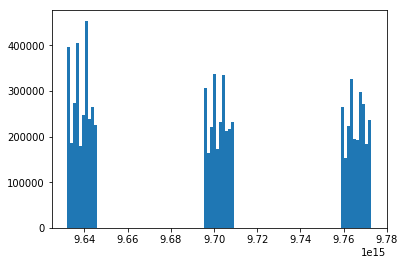

In [10]:
plt.hist(bids_sorted_by_time['time'], bins=100)
plt.show()

Looks like there are 3 distinct periods of bids.

Would be interesting to see how balanced the dataset is.

### Bids balance

In [11]:
bids_joined = bids.merge(train_df[['bidder_id', 'outcome']], left_on='bidder_id', right_on='bidder_id')

In [12]:
breakdown = bids_joined[['bid_id', 'outcome']].groupby('outcome').count()['bid_id']

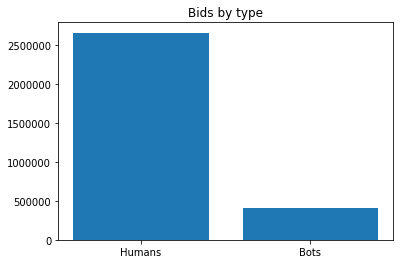

In [13]:
plt.title('Bids by type')
plt.bar(['Humans', 'Bots'], breakdown)
plt.show()

### Dataset description

In [14]:
bids.describe(include='all')

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
count,"7,656,334.00",7656334,7656334,7656334,7656334,"7,656,334.00",7647475,7656334,7656334
unique,nan,6614,15051,10,7351,nan,199,2303991,1786351
top,nan,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,jqx39,mobile,phone4,nan,in,37.95.134.218,vasstdc27m7nks3
freq,nan,515033,537347,2126587,706573,nan,1788731,61203,3499409
mean,"3,828,166.50",NaN,NaN,NaN,NaN,"9,697,977,781,760,554.00",NaN,NaN,NaN
std,"2,210,193.39",NaN,NaN,NaN,NaN,"52,505,176,512,005.31",NaN,NaN,NaN
min,0.00,NaN,NaN,NaN,NaN,"9,631,916,842,105,264.00",NaN,NaN,NaN
25%,"1,914,083.25",NaN,NaN,NaN,NaN,"9,641,138,736,842,104.00",NaN,NaN,NaN
50%,"3,828,166.50",NaN,NaN,NaN,NaN,"9,700,653,894,736,842.00",NaN,NaN,NaN
75%,"5,742,249.75",NaN,NaN,NaN,NaN,"9,761,744,315,789,472.00",NaN,NaN,NaN


## Feature eng

Firstly, some of my own features.

### Number of unique devices per bidder

In [15]:
unique_devices = bids.groupby('bidder_id')['device'].nunique().rename('NUM_UNIQUE_DEVICES')

In [16]:
train_df = train_df.join(unique_devices, on='bidder_id')

### Mean unique devices per auction per bidder

In [17]:
mean_unique_per_auction = bids.groupby(['bidder_id', 'auction'])['device'].nunique().groupby('bidder_id').mean().rename('MEAN_UNIQUE_DEVICES_PER_AUCTION')

In [18]:
train_df = train_df.join(mean_unique_per_auction, on='bidder_id')

### Number unique auctions per bidder

In [19]:
unique_auctions = bids.groupby('bidder_id')['auction'].nunique().rename('NUM_UNIQUE_AUCTIONS')

In [20]:
train_df = train_df.join(unique_auctions, on='bidder_id')

### Mean bids per auction

In [21]:
avg_bids_per_auction = bids.groupby(['bidder_id', 'auction'])['bid_id'].count().groupby('bidder_id').mean().rename('AVG_BIDS_PER_AUCTION')

In [22]:
train_df = train_df.join(avg_bids_per_auction, on='bidder_id')

### Total unique countries

In [23]:
total_unique_countries = bids.groupby('bidder_id')['country'].nunique()

In [24]:
train_df = train_df.join(total_unique_countries, on='bidder_id')

### Mean unique countries per auction

In [25]:
avg_unique_countries_per_auction = bids.groupby(['bidder_id', 'auction'])['country'].nunique().groupby('bidder_id').mean().rename('AVG_UNIQUE_COUNTRIES_PER_AUCTION')

In [26]:
train_df = train_df.join(avg_unique_countries_per_auction, on='bidder_id')

### Mean bids per country

In [27]:
bids_country_one_hot = pd.get_dummies(bids, columns=['country'])

In [28]:
new_cols = [c for c in bids_country_one_hot.columns if 'country' in c]

In [29]:
avg_bid_by_country = bids_country_one_hot[['bidder_id', 'auction'] + new_cols].groupby(['bidder_id', 'auction']).sum().groupby('bidder_id').mean()

In [30]:
avg_bid_by_country.columns = pd.Index([f'MEAN_BIDS_{c.upper()}' for c in avg_bid_by_country.columns])

In [31]:
train_df = train_df.join(avg_bid_by_country, on='bidder_id')

### Breakdown per merchandise type

In [32]:
bids_merch_one_hot = pd.get_dummies(bids, columns=['merchandise'])

In [33]:
new_cols = [c for c in bids_merch_one_hot.columns if 'merchandise' in c]

In [34]:
avg_merch_per_auction_breakdown = bids_merch_one_hot[['bidder_id', 'auction'] + new_cols].groupby(['bidder_id', 'auction']).sum().groupby('bidder_id').mean()

In [35]:
avg_merch_per_auction_breakdown.columns = pd.Index([f'AVG_{c.upper()}' for c in avg_merch_per_auction_breakdown.columns])

In [36]:
train_df = train_df.join(avg_merch_per_auction_breakdown, on='bidder_id')

### Total unique ip addresses

In [37]:
count_unique_ips = bids.groupby('bidder_id').ip.nunique().rename('COUNT_UNIQUE_IPS')

In [38]:
train_df = train_df.join(count_unique_ips, on='bidder_id')

### Unique ips per auction

In [39]:
unique_ips_per_auction = bids.groupby(['bidder_id', 'auction']).ip.nunique().groupby('bidder_id').mean().rename('UNIQUE_IPS_PER_AUCTION')

In [40]:
train_df = train_df.join(unique_ips_per_auction, on='bidder_id')

The winners of the competition shared their feature engineering techniques in this article: https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/discussion/14628

The second place winner said that the most useful features were:

* the median time between a user's bid and that user's previous bid
* the mean number of bids a user made per auction
* the entropy for how many bids a user placed on each day of the week
* the means of the per-auction URL entropy and IP entropy for each user
* the maximum number of bids in a 20 min span
* the total number of bids placed by the user
* the average number of bids a user placed per referring URL
* the number of bids placed by the user on each of the three weekdays in the data
* the minimum and median times between a user's bid and the previous bid by another user in the same auction.
* the fraction of IPs used by a bidder which were also used by another user which was a bot

I'll create those features initially.

### Median time between user's bids

1. Sort by bid time.
2. Diff the bid times.
3. Take the median diff per user.

In [41]:
def median_time_between_bids(df):
    bidder_ids_to_mean_diff = defaultdict(list)

    grp = df.groupby(['bidder_id', 'auction'])

    for key, df in grp:
        bidder_id, auction = key
        mean_value = df.sort_values('time')['time'].diff().mean()
        if np.isnan(mean_value):
            continue

        bidder_ids_to_mean_diff[bidder_id].append(mean_value)

    bidder_ids = []
    medians = []

    for bidder_id, diffs in bidder_ids_to_mean_diff.items():
        bidder_ids.append(bidder_id)
        medians.append(np.median(diffs))

    output = pd.DataFrame({'bidder_id': bidder_ids, 'median_between_bids': medians})
    return output.set_index('bidder_id')

In [42]:
# Test media time function.

test_dfs = pd.DataFrame({
    'bidder_id': ['abc123', 'abc123', 'abc123', 'abc123', 'abc124', 'abc124', 'abc124'],
    'time': [1000, 1002, 2000, 2002, 1000, 1005, 1006],
    'auction': ['a1', 'a1', 'a2', 'a2', 'a1', 'a1', 'a1']})
median_times = median_time_between_bids(test_dfs)
assert median_times[median_times.index == 'abc123']['median_between_bids'].values[0] == 2

In [43]:
%%time
median_df = median_time_between_bids(sample_bids)

CPU times: user 7.15 s, sys: 68.7 ms, total: 7.21 s
Wall time: 7.24 s


In [44]:
median_df.head()

,median_between_bids
bidder_id,
01067975436d123f717ee5aba0dd4bbfa0937,"1,190,786,715,343.37"
01255c2c7c5578c186873422fc00fd7afwk8k,"1,901,720,604,703.05"
0318e0a173f7c65db40116b903884c854x258,"406,592,656,379.00"
0496c24a6a7f593f28bf7896350e946advl6i,"1,064,157,894,736.67"
05c9fe8f8852ea069a93dfe39fc0571er9mdt,"4,113,315,789,474.00"


In [45]:
train_df['AVG_TIME_BETWEEN_BIDS'] = train_df['bidder_id'].map(median_df['median_between_bids'])

### Entropy for how many bids a user placed on each day of the week

In [46]:
# To do

### Mean of the per-auction URL entropy and IP entropy for each user

### Maximum number of bids in a 20 minute window

* Calculate all 20 minute windows in dataset.


### Total number of bids placed by the user

In [47]:
total_bids_per_user = sample_bids.groupby(by=['bidder_id'])['bid_id'].count()

train_df['TOTAL_BIDS'] = train_df['bidder_id'].map(total_bids_per_user)
train_df['TOTAL_BIDS'] = train_df['TOTAL_BIDS'].fillna(0)

## Train

Start by training a LightGBM classifier.

In [48]:
target = train_df.pop('outcome')

In [98]:
folds = KFold(n_splits=8, shuffle=True, random_state=546789)

oof_preds = np.zeros(train_df.shape[0])

feats = [f for f in train_df.columns if f not in ['bidder_id', 'payment_account', 'address']]
feature_importance_df = pd.DataFrame()

best_iterations = []

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_df)):
    train_X, train_y = train_df[feats].iloc[trn_idx], target.iloc[trn_idx]
    val_X, val_y = train_df[feats].iloc[val_idx], target.iloc[val_idx]
    
    model = LGBMRegressor()
    
    model.fit(train_X, train_y)
    
    oof_preds[val_idx] = model.predict(val_X)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print(f'Fold {n_fold + 1} AUC: {roc_auc_score(val_y, oof_preds[val_idx])}')

print(f'Full AUC score: {roc_auc_score(target, oof_preds)}')

Fold 1 AUC: 0.937814357567444
Fold 2 AUC: 0.7299645960733827
Fold 3 AUC: 0.8553266816865144
Fold 4 AUC: 0.9187060478199718
Fold 5 AUC: 0.8840277777777777
Fold 6 AUC: 0.9170243204577967
Fold 7 AUC: 0.7670850767085078
Fold 8 AUC: 0.7859848484848486
Full AUC score: 0.8531871092360088


In [ ]:
total_feat_importance = feature_importance_df[["feature", "importance"]].groupby('feature').mean().sort_values(by='importance', ascending=False)
total_feat_importance['feature'] = total_feat_importance.index

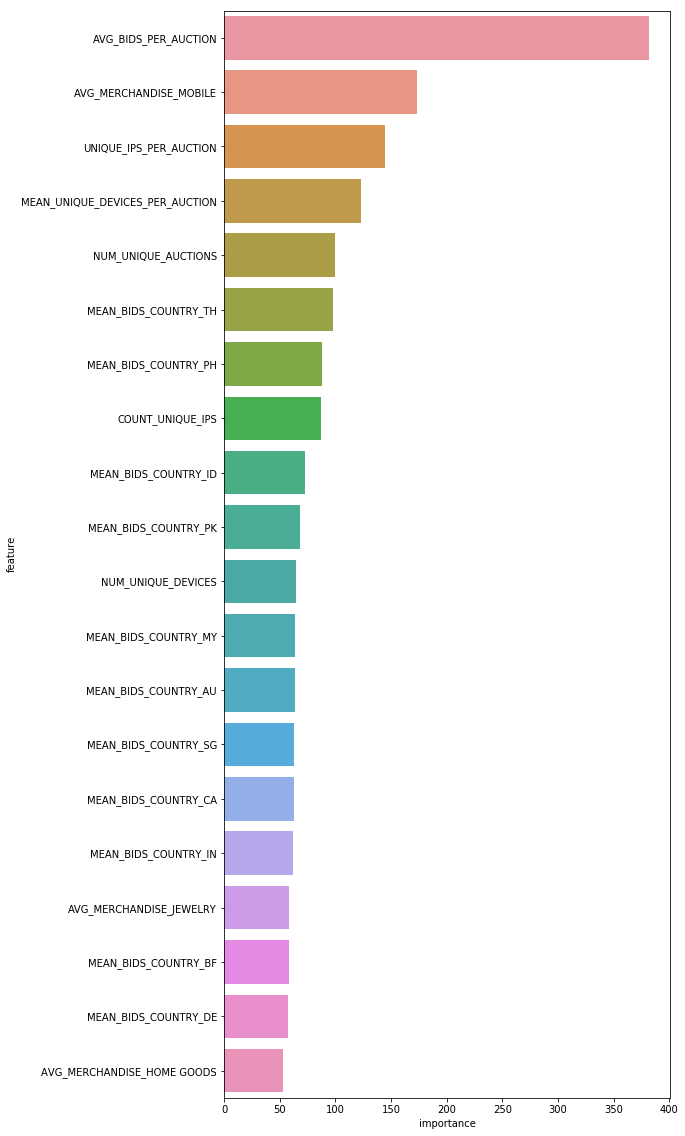

In [84]:
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature",
    data=total_feat_importance.head(20))